<a href="https://colab.research.google.com/github/amplabs-ai/amplabs/blob/main/MRS_Sandia_AmpLabs_Example_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MRS - Sandia AmpLabs Example 3






In this demo you will learn how to:

1. Fetch battery data from **AmpLabs JSON API**
2. Define new metrics and add them as new corresponding columns using **Pandas**
3. Plot graphs using **Matplotlib**


We will use the following Python libraries and tools

**Pandas** is an easy-to-use data structures and data analysis tools for the Python programming language. In Pandas, we can import data from various file formats like JSON, SQL, Microsoft Excel, etc. When working with tabular data, such as data stored in spreadsheets or databases, pandas will help you to explore, clean, and process your data. In pandas, a data table is called a **Data Frame**.

Note: Pandas is built off of another library called **NumPy**. 

**Matplotlib** Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python. Matplotlib makes easy things easy and hard things possible.



In [ ]:
# Mount Google Drive 

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Install necessary libraries


In [1]:
# Download python packages to your system using pip install
import sys
!{sys.executable} -m pip install pandas scipy requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import the libraries we downloaded into the Python environment


In [2]:
# Useful for fetching data from the web 

import json
import requests

# PyData Libraries

import scipy.io
import pandas as pd
import matplotlib.pyplot as plt

# Library useful for rendering Images and suppressing warnings in Jupyter Notebooks

from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

# Define Helper Function

In [7]:
def get_amplabs_data(cell_id):
    url = "https://www.app.amplabs.ai/download/cells/cycle_data_json?cell_id={}".format(cell_id.replace('/', '%2F'))
    user_token = "<token>"
    headers = {
    'Authorization': 'Bearer {}'.format(user_token),
    }
    try:
        response = requests.request("GET", url, headers=headers)
        res =  json.loads(response.text)
        response = requests.request("GET",res["response_url"])
        response = gzip.decompress(response.content)
        return json.loads(response.decode())
    except requests.exceptions.RequestException as e:
        print(e)
    return None


In [10]:
#Fetch Data from Amplabs API
cell_id = "SNL_18650_LFP_25C_0-100_0.5/1C_a"
response = get_amplabs_data(cell_id)

df_cell = pd.DataFrame(response['records'][0])

print("Process complete", df_cell.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 49 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   charge_step_count                    0 non-null      object 
 1   cycle_charge_capacity                510 non-null    float64
 2   cycle_charge_energy                  510 non-null    float64
 3   cycle_coulombic_efficiency           510 non-null    float64
 4   cycle_discharge_capacity             510 non-null    float64
 5   cycle_discharge_energy               510 non-null    float64
 6   cycle_duration                       512 non-null    float64
 7   cycle_end_timestamp                  512 non-null    object 
 8   cycle_energy_efficiency              510 non-null    float64
 9   cycle_index                          512 non-null    int64  
 10  cycle_max_charge_power               510 non-null    float64
 11  cycle_max_current               

In [ ]:
file_name = '/content/drive/MyDrive/MRS/Gr-LFP_127662duty.mat'

# import data from the Matlab .mat file
# scipy converts the mat struct in a Python struct
data_scipy = scipy.io.loadmat(file_name)
data_scipy.keys()

In [ ]:
for key in data_scipy:
  print(key, type(data_scipy[key]))

__header__ <class 'bytes'>
__version__ <class 'str'>
__globals__ <class 'list'>
LAMNEeq <class 'numpy.ndarray'>
LAMPEeq <class 'numpy.ndarray'>
LLIeq <class 'numpy.ndarray'>
QL <class 'numpy.ndarray'>
Vi <class 'numpy.ndarray'>
cyc <class 'numpy.ndarray'>
key <class 'numpy.ndarray'>
p1 <class 'numpy.ndarray'>
p2 <class 'numpy.ndarray'>
p3 <class 'numpy.ndarray'>
p4 <class 'numpy.ndarray'>
p5 <class 'numpy.ndarray'>
p6 <class 'numpy.ndarray'>
p7 <class 'numpy.ndarray'>
p8 <class 'numpy.ndarray'>


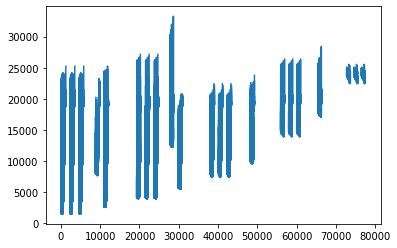

In [11]:
# Calculate the normalized capacity
# Ensure that the data is converted to numeric values
df_cell['cycle_discharge_capacity'] = pd.to_numeric(df_cell['cycle_discharge_capacity'])

# Normalize the capacity using the initial cell capacity
df_cell['Ah_loss'] = 100.0*(df_cell['cycle_discharge_capacity'])/df_cell['cycle_discharge_capacity'].iloc[0]

# Switch from capacity loss to capacity remaining
QL = 100.0 - data_scipy['QL']

# Import the degradation components
LAMNEeq = data_scipy['LAMNEeq']
LAMPEeq = data_scipy['LAMPEeq']
LLIeq = data_scipy['LLIeq']
cyc = data_scipy['cyc']

#Experimental data start from 1, not 0. We are assuming cycle 1 of the experiments is equivalent to cycle 0 of the synthetic data
cyc[0, 0] = 1

# filter cell data by the cycles available in the Matlab database
df_cell_ah_loss = df_cell[df_cell.cycle_index.isin(cyc[0])]

# move to arrays to calculate min squared error
Ah_loss = df_cell_ah_loss['Ah_loss'].to_numpy()

# Calculate all the residuals -- this is how to work directly with arrays elements

delta = []

j = 0

for x in QL:

    i = 0
    delta_v = 0

    for k in x:
        delta_v += (k-Ah_loss[i])**2
        i += 1

    delta.append(delta_v)

# Plot the residuals
plt.plot(delta)

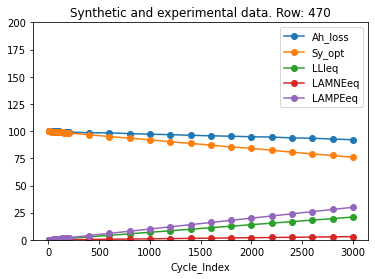

In [ ]:
# find the minimum error and the corresponding index
min_value = min(delta)
min_index = delta.index(min_value)

# Collect all the info in one dataframe
df_cell_ah_loss['LLIeq'] = LLIeq[min_index].transpose()
df_cell_ah_loss['LAMNEeq'] = LAMNEeq[min_index].transpose()
df_cell_ah_loss['LAMPEeq'] = LAMPEeq[min_index].transpose()
df_cell_ah_loss['Sy_opt'] = QL[min_index].transpose()


# Plot synthetic and experimental data
df_cell_ah_loss.plot(x='cycle_index', y=["Ah_loss", "Sy_opt", "LLIeq", "LAMNEeq", "LAMPEeq"], marker="o")
plt.title('Synthetic and experimental data. Row: ' + str(min_index))
plt.xlabel('Cycle_Index')
plt.ylim([0, 200])
plt.legend()
plt.show()